In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Review classifier

In [205]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from nltk.stem.wordnet import WordNetLemmatizer


In [223]:
# Import winning Wentiment analysis model

df = pd.read_csv("/content/drive/Othercomputers/Mon ordinateur portable/Project Review Aggregator/data/kag_comb_clean_PySentimiento.csv")

df.columns

Index(['brand', 'categories', 'id', 'manufacturer', 'name',
       'reviews.doRecommend', 'reviews.id', 'reviews.rating', 'reviews.text',
       'reviews.title', 'reviews.username', 'sentiment', 'clean title',
       'clean review', 'title sentiment', 'review sentiment',
       'title sentiment details', 'review sentiment details',
       'merged PySent sentiment', 'PySent correct'],
      dtype='object')

## Prepare data

Merge column for efficient classification

In [224]:
print(df['brand'].unique(), end='\n \n')

print(df['manufacturer'].unique(), end='\n \n')

# print(df['name'].unique(), end='\n \n')

# print(df['categories'].unique(), end='\n \n')



['Amazon' 'Amazonbasics' 'AmazonBasics' 'Amazon Fire' 'Amazon Echo'
 'Amazon Fire Tv' 'Amazon Digital Services Inc.']
 
['Amazon' 'AmazonBasics' 'Amazon Digital Services' 'Amazon.com'
 'Amazon Digital Services, Inc']
 


In [225]:
# remove lines with product = "nan"
# Remove rows where "name" is NaN
df = df.dropna(subset=['name'])

# Clean Amazon from product name because it's present in brands

def remove_amazon_from_column(df, column_name):
    """
    Removes the words 'Amazon' or 'amazon' (case-insensitive) from a specified column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to process.

    Returns:
        pd.DataFrame: A DataFrame with the modified column.
    """
    # Define the regex pattern
    pattern = r'\b[Aa]mazon\b'

    # Apply the regex to the specified column
    df[column_name] = df[column_name].apply(lambda x: re.sub(pattern, '', str(x)))

    return df

remove_amazon_from_column(df, 'name')

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username,sentiment,clean title,clean review,title sentiment,review sentiment,title sentiment details,review sentiment details,merged PySent sentiment,PySent correct
0,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",False,NaN,3.0,I thought it would be as big as small paper bu...,Too small,llyyue,NEU,too small,i thought it would be as big as small paper bu...,NEU,NEG,"{'label': 'NEU', 'probas': {'NEG': 0.214903503...","{'label': 'NEG', 'probas': {'NEG': 0.880224943...",NEG,False
1,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,5.0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,POS,great light reader. easy to use at the beach,this kindle is light and easy to use especiall...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.001225944...","{'label': 'POS', 'probas': {'NEG': 0.001145137...",POS,True
2,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,4.0,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,POS,great for the price,didnt know how much i'd use a kindle so went f...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.022799693...","{'label': 'POS', 'probas': {'NEG': 0.002035730...",POS,True
3,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,177283626.0,5.0,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,POS,a great buy,i am 100 happy with my purchase. i caught it o...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.002319600...","{'label': 'POS', 'probas': {'NEG': 0.002211279...",POS,True
4,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,5.0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,POS,solid entry-level kindle. great for kids,solid entry level kindle. great for kids. gift...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.001506322...","{'label': 'POS', 'probas': {'NEG': 0.001497109...",POS,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42088,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",AVpfl8cLLJeJML43AE3S,Amazon,New Kindle Fire Hd 9w Powerfast Adapter Charg...,True,NaN,5.0,This is my new favorite device. While not perf...,My new favorite product,JefferyP,POS,my new favorite product,this is my new favorite device. while not perf...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.001614185...","{'label': 'POS', 'probas': {'NEG': 0.003222834...",POS,True
42089,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",AVpfl8cLLJeJML43AE3S,Amazon,New Kindle Fire Hd 9w Powerfast Adapter Charg...,True,NaN,5.0,I got this to basically experiment with. Strai...,Lots of potential!!!,shelbydave,POS,lots of potential!!!,i got this to basically experiment with. strai...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.001686587...","{'label': 'POS', 'probas': {'NEG': 0.020290784...",POS,True
42090,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",AVpfl8cLLJeJML43AE3S,Amazon,New Kindle Fire Hd 9w Powerfast Adapter Charg...,True,NaN,4.0,Good product that does the basics. Too bad you...,Good First Generation Product,Tiredofchoosingnicknames,POS,good first generation product,good product that does the basics. too bad you...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.002019575...","{'label': 'POS', 'probas': {'NEG': 0.010307939...",POS,True
42091,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",AVpfl8cLLJeJML43AE3S,Amazon,New K

In [226]:
# Merging columns into a new column

    # Basic merge
df['classifier src 0'] = df['brand'] + ' ' + df['name'] + ' ' + df['categories']

    # Deeper Merge
df['classifier src 1'] = df['name']

    # Super deep merge
df['classifier src 2'] = df['name'] + ' ' + df['categories']

    # Shallow merge
df['classifier src 3'] = df['categories']

Clean text + Lemmatize + Bag of Words + TF-IDF

In [227]:
import nltk
nltk.download('stopwords')

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load stop words
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Turn into strings
    text = str(text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Keep only letters and spaces

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove all single characters
    text = re.sub(r'\b[a-zA-Z]\b', ' ', text)  # Remove isolated single letters

    # Remove single characters from the start
    text = re.sub(r'\b[a-zA-Z]\s+', ' ', text)

    # Remove prefixed 'b' (commonly from bytes conversion)
    text = re.sub(r'\bb\b', ' ', text)

    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Convert to lowercase
    text = text.lower()

    # Tokenize text
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Lemmatize each word
    text = ' '.join([lemmatizer.lemmatize(word) for word in words])

    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [228]:
import nltk

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [229]:
# Run and create new column in DF

df['classifier lemma src 0'] = df['classifier src 0'].apply(preprocess)

df['classifier lemma src 1'] = df['classifier src 1'].apply(preprocess)

df['classifier lemma src 2'] = df['classifier src 2'].apply(preprocess)

df['classifier lemma src 3'] = df['classifier src 3'].apply(preprocess)

In [230]:
df.head(5)

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,...,merged PySent sentiment,PySent correct,classifier src 0,classifier src 1,classifier src 2,classifier src 3,classifier lemma src 0,classifier lemma src 1,classifier lemma src 2,classifier lemma src 3
0,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",False,NaN,3.0,I thought it would be as big as small paper bu...,Too small,...,NEG,False,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...
1,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,5.0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,...,POS,True,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...
2,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,4.0,Didnt know how much i'd use a kindle so went f...,Great for the price,...,POS,True,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...
3,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,177283626.0,5.0,I am 100 happy with my purchase. I caught it o...,A Great Buy,...,POS,True,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...
4,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,5.0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,...,POS,True,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...


In [231]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# 1. TF-IDF for each column
tfidf_0 = tfidf_vectorizer.fit_transform(df['classifier lemma src 0']) #.astype(str))
tfidf_1 = tfidf_vectorizer.fit_transform(df['classifier lemma src 1']) #.astype(str))
tfidf_2 = tfidf_vectorizer.fit_transform(df['classifier lemma src 2']) #.astype(str))
tfidf_3 = tfidf_vectorizer.fit_transform(df['classifier lemma src 2']) #.astype(str))


# Store all TF-IDF representations in a dictionary
tfidf_matrices = {
    'TF-IDF Column 0': tfidf_0,
    'TF-IDF Column 1': tfidf_1,
    'TF-IDF Column 2': tfidf_2,
    'TF-IDF 3': tfidf_3
}


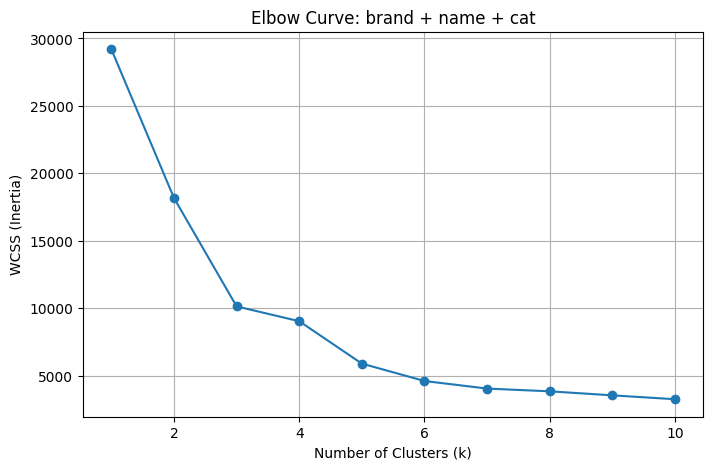

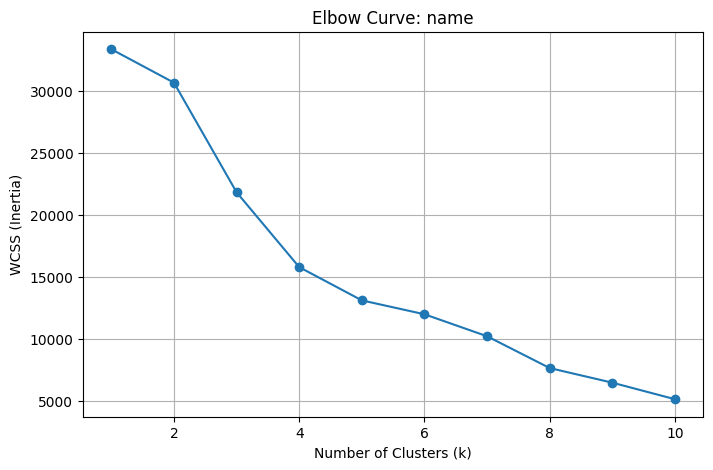

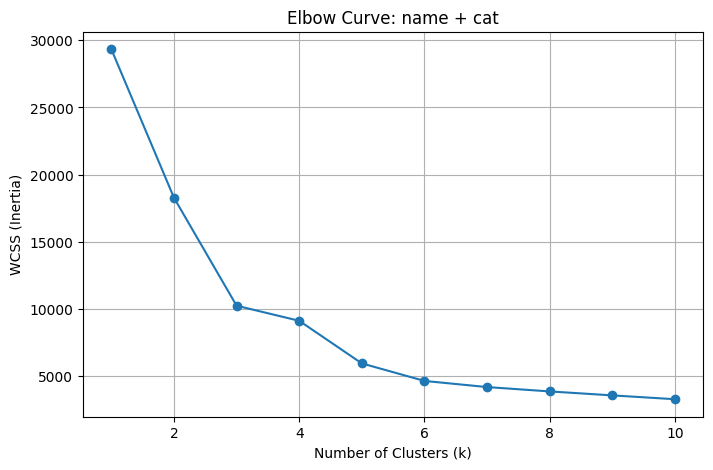

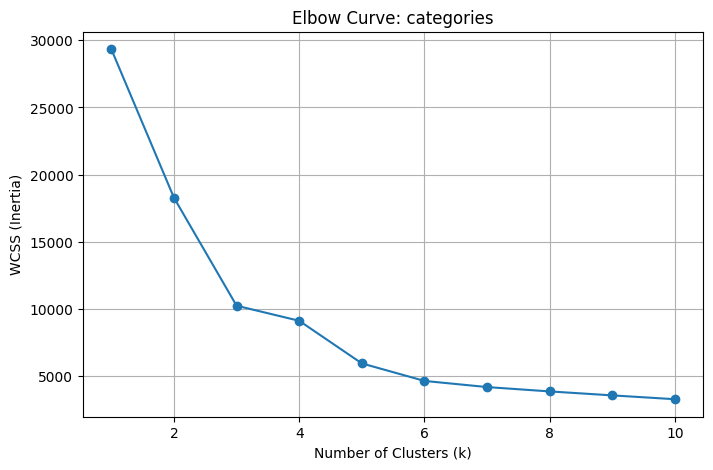

In [232]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to compute WCSS and plot Elbow Curve
def plot_elbow_curve(tfidf_matrix, title):
    wcss = []
    cluster_range = range(1, 11)  # Test for cluster sizes 1 to 10

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tfidf_matrix)
        wcss.append(kmeans.inertia_)

    # Plot Elbow Curve
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, wcss, marker='o')
    plt.title(f'Elbow Curve: {title}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.grid(True)
    plt.show()

# Plot Elbow Curve for each TF-IDF matrix
tfidf_matrices2 = {
    'brand + name + cat': tfidf_0,
    'name': tfidf_1,
    'name + cat': tfidf_2,
    'categories': tfidf_3
}

for name, tfidf_matrix in tfidf_matrices2.items():
    plot_elbow_curve(tfidf_matrix, name)




## Using clasifier 0

In [245]:
# Set the optimal number of clusters (adjust based on the elbow curve)
optimal_clusters = 6

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_0)

# Display the first few rows with cluster assignments
df.head()

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,...,classifier src 0,classifier src 1,classifier src 2,classifier src 3,classifier lemma src 0,classifier lemma src 1,classifier lemma src 2,classifier lemma src 3,cluster,cluster_name
0,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",False,NaN,3.0,I thought it would be as big as small paper bu...,Too small,...,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...,4,"['toy', 'computer', 'reader', 'electronics', '..."
1,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,5.0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,...,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...,4,"['toy', 'computer', 'reader', 'electronics', '..."
2,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,4.0,Didnt know how much i'd use a kindle so went f...,Great for the price,...,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...,4,"['toy', 'computer', 'reader', 'electronics', '..."
3,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,177283626.0,5.0,I am 100 happy with my purchase. I caught it o...,A Great Buy,...,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...,4,"['toy', 'computer', 'reader', 'electronics', '..."
4,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Kindle E-Reader 6"" Wifi (8th Generation, 2016)",True,NaN,5.0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,...,"Amazon Kindle E-Reader 6"" Wifi (8th Generatio...","Kindle E-Reader 6"" Wifi (8th Generation, 2016)","Kindle E-Reader 6"" Wifi (8th Generation, 2016...","Computers,Electronics Features,Tablets,Electro...",amazon kindle reader wifi th generation comput...,kindle reader wifi th generation,kindle reader wifi th generation computer elec...,computer electronics feature tablet electronic...,4,"['toy', 'computer', 'reader', 'electronics', '..."


In [246]:
import numpy as np

# Get the feature names from the vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Function to get top keywords for each cluster
def get_top_keywords(tfidf_0, labels, feature_names, n_words=5):
    top_keywords = {}
    for cluster in set(labels):
        # Get the indices of the titles in this cluster
        indices = np.where(labels == cluster)
        # Compute the mean TF-IDF score for each word in the cluster
        mean_tfidf = tfidf_0[indices].mean(axis=0)
        # Get the top n words with the highest TF-IDF scores
        top_n_words = feature_names[np.argsort(mean_tfidf)[0, -n_words:]].tolist()
        top_keywords[cluster] = [str(word) for word in top_n_words[::-1]]  # Ensure all are strings
    return top_keywords

# Get the top keywords for each cluster
cluster_keywords = get_top_keywords(tfidf_0, df['cluster'].values, feature_names, n_words=5)

# Display the possible cluster names
for cluster, keywords in cluster_keywords.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")


Cluster 0: ['new', 'amazon', 'computer', 'hd', 'tablet']
Cluster 1: ['echo', 'audio', 'speaker', 'smart', 'home']
Cluster 2: ['camera', 'care', 'household', 'health', 'battery']
Cluster 3: ['electronics', 'fry', 'magenta', 'android', 'tablet']
Cluster 4: ['ereaders', 'ebook', 'kindle', 'tablet', 'reader']
Cluster 5: ['edition', 'proof', 'case', 'tablet', 'kid']


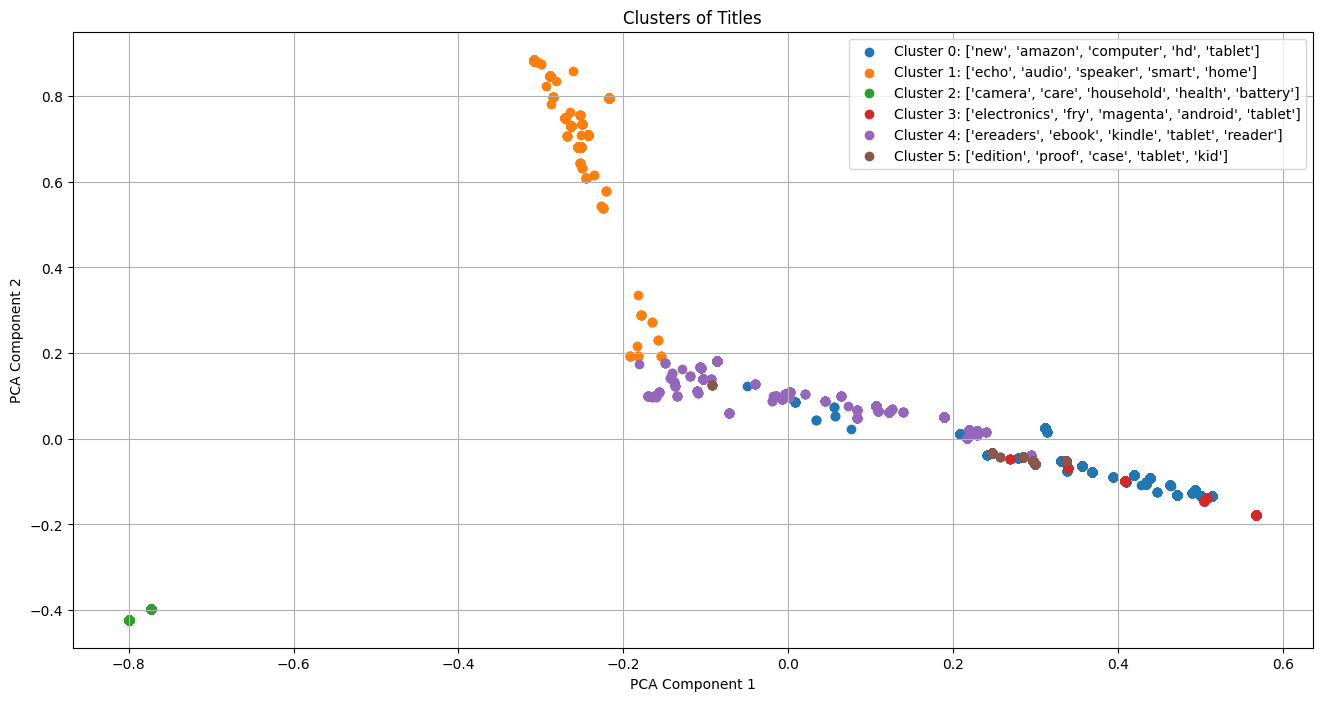

In [247]:
# !pip install scikit-learn # Installing scikit-learn if not already installed
from sklearn.decomposition import PCA # Importing PCA from sklearn.decomposition

pca = PCA(n_components=2, random_state=42)
tfidf_0_pca = pca.fit_transform(tfidf_0.toarray())

# Add possible cluster names to the DataFrame
df['cluster_name'] = df['cluster'].apply(lambda x: ', '.join(cluster_keywords[x]))

# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2, random_state=42)
tfidf_0_pca = pca.fit_transform(tfidf_0.toarray())

# Plot the clusters
plt.figure(figsize=(16, 8))
for cluster in set(df['cluster']):
    # Extract the cluster name (assuming all rows in the same cluster have the same cluster_name)
    cluster_label = df[df['cluster'] == cluster]['cluster_name'].iloc[0]

    plt.scatter(
        tfidf_0_pca[df['cluster'] == cluster, 0],
        tfidf_0_pca[df['cluster'] == cluster, 1],
        label=f'Cluster {cluster}: {cluster_label}'
    )

plt.title('Clusters of Titles')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

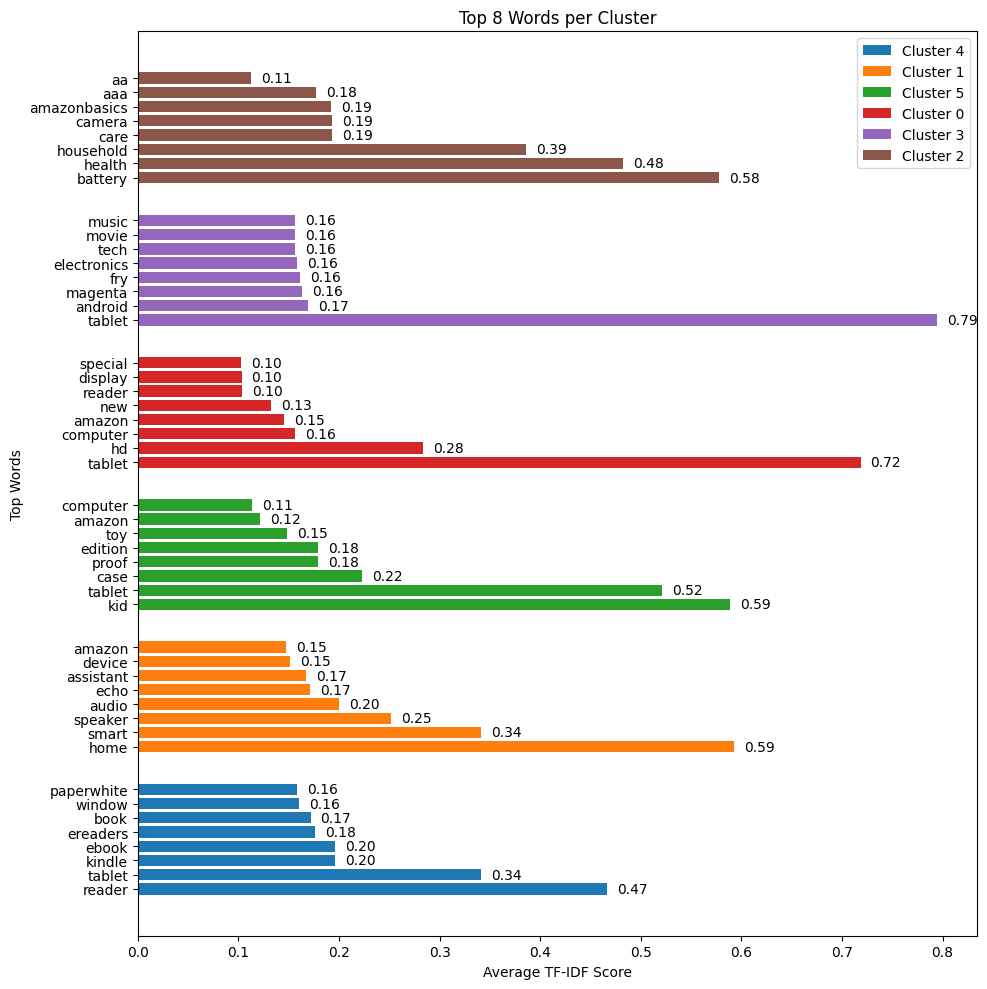

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Example: Replace with your real TF-IDF vectorizer and data
# vectorizer = TfidfVectorizer()  # Use the vectorizer you used for `tfidf_0`
# tfidf_0 = vectorizer.fit_transform(your_text_data)  # Example transformation
# df['cluster'] = cluster_labels  # Assuming cluster labels are already in the DataFrame

# Get feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame of TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_0.toarray(), columns=feature_names)

# Add cluster labels to the TF-IDF DataFrame
tfidf_df['cluster'] = df['cluster']

# Extract top 8 words for each cluster
top_words_per_cluster = {}
for cluster in tfidf_df['cluster'].unique():
    cluster_data = tfidf_df[tfidf_df['cluster'] == cluster].drop(columns=['cluster'])
    mean_tfidf = cluster_data.mean(axis=0)  # Average TF-IDF scores per word in the cluster
    top_words = mean_tfidf.sort_values(ascending=False).head(8)  # Changed from head(5) to head(8)
    top_words_per_cluster[cluster] = top_words

# Plot horizontal bar chart
plt.figure(figsize=(10, 10))
for i, (cluster, top_words) in enumerate(top_words_per_cluster.items()):
    words = top_words.index
    scores = top_words.values
    y_positions = range(len(words))
    plt.barh([y + i * 10 for y in y_positions], scores, label=f'Cluster {cluster}')  # Adjust spacing
    for y, score in zip(y_positions, scores):
        plt.text(score + 0.01, y + i * 10, f'{score:.2f}', va='center')

# Customize the chart
plt.yticks(
    [y + i * 10 for i, words in enumerate(top_words_per_cluster.values()) for y in range(len(words))],
    [word for words in top_words_per_cluster.values() for word in words.index]
)
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Top Words')
plt.title('Top 8 Words per Cluster')
plt.legend()
plt.tight_layout()
plt.show()



## Final clusters proposed

Cluster 0: Amazon tablets

Cluster 1: Speakers

Cluster 2: Household accessories (batteries etc)

Cluster 3: New Amazon tablets

Cluster 4: Kindles & e-reader

Cluster 5: Kid and toy accessories